# Lab 4-1: Linear regression

---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

Load in a csv file with snow water equivalent (SWE) measurements from two snow pillow sites (which measure the mass of snow) in California's Sierra Nevada. 

(If you're interested, [read about SWE and snow pillows here](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/null/?cid=nrcseprd1314833))

In [2]:
data = pd.read_csv('pillows_example.csv')

data.head(3)

,years,BLC_max,SLI_max
0,1983,688,2446
1,1984,112,1471
2,1985,216,1143


This data give us the peak SWE value (mm) at the Blue Canyon (BLC), and Slide Canyon (SLI) measurement sites.

Plot the SWE data from the two sites

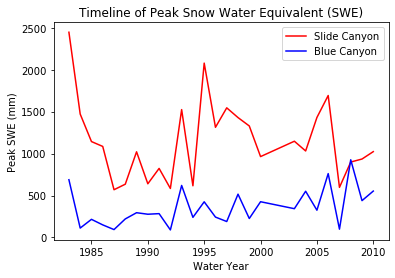

In [3]:
fig, ax = plt.subplots()

data.plot(x='years', y='SLI_max', c='r', ax=ax, label='Slide Canyon')
data.plot(x='years', y='BLC_max', c='b', ax=ax, label='Blue Canyon')

ax.set_title('Timeline of Peak Snow Water Equivalent (SWE)')
ax.set_xlabel('Water Year')
ax.set_ylabel('Peak SWE (mm)');
plt.legend(loc="best")

**What does the above plot show?**

What you see above is a plot of the maximum value of snow water equivalent (SWE) measured at two snow pillows (these weigh the snow and convert that weight into the water content of the snow). These measurements of snow are not too far from each other geographically (both in the Sierra Nevada, California, although Slide Canyon is at a higher elevation and further south), and we might expect that more snow at one site woud correspond to more snow at the other site as well. We can check this by examining a regression between the data at the two sites.


**The first step to any regression or correlation analysis is to create a scatter plot of the data.**


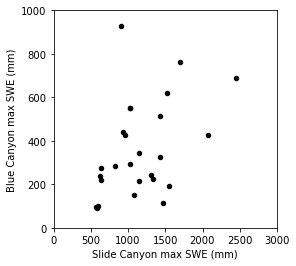

In [4]:
fig, ax = plt.subplots(figsize=(4,4))

# Scatterplot
data.plot.scatter(x='SLI_max', y='BLC_max', c='k', ax=ax);

ax.set_xlabel('Slide Canyon max SWE (mm)')
ax.set_ylabel('Blue Canyon max SWE (mm)');

ax.set_xlim((0,3000))
ax.set_ylim((0,1000));

**Linear regression**: Could we use SWE measurements at Slide Canyon to predict SWE at Blue Canyon?

The plot above suggests that this is a borderline case for applying linear regression analysis. What rules of linear regression might we worry about here? ([*heteroscedasticity*](https://en.wikipedia.org/wiki/Heteroscedasticity))

We will proceed with calculating the regression and then look at the residuals to get a better idea of whether this is the best approach.

---

### Manual calculation of linear regression

Here we'll first compute it manually, solving for our y-intercept, $B_0$, and slope $B_1$:

$B_1 = \displaystyle \frac{n(\sum_{i=1}^{n}x_iy_i)-(\sum_{i=1}^{n}x_i)(\sum_{i=1}^{n}y_i)}{n(\sum_{i=1}^{n}x_i^2)-(\sum_{i=1}^{n}x_i)^2}$

$B_0 = \displaystyle \frac{(\sum_{i=1}^{n}y_i)-B_1(\sum_{i=1}^{n}x_i)}{n} = \bar{y} - B_1\bar{x}$

In [5]:
n = len(data) # length of our dataset

x = data.SLI_max # using x for shorthand below
y = data.BLC_max # using y for shorthand below

B1 = ( n*np.sum(x*y) - np.sum(x)*np.sum(y) ) / ( n*np.sum(x**2) - np.sum(x)**2 ) # B1 parameter, slope
B0 = np.mean(y) - B1*np.mean(x) # B0 parameter, y-intercept

print('B0 : {}'.format(np.round(B0,4)))
print('B1 : {}'.format(np.round(B1,4)))

B0 : 127.9143
B1 : 0.1997


Then our linear model to predict $y$ at each $x_i$ is: $\hat{y}_i = B_0 + B_1x_i$

In [6]:
y_predicted = B0 + B1*x

And our residuals are: $(y_i - \hat{y}_i)$

In [7]:
residuals = (y - y_predicted)

Finally, compute our Sum of Squared Errors (from our residuals) and Total Sum of Squares to get the correlation coefficient, R, for this linear model.

$SSE = \displaystyle\sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ 

$SST = \displaystyle\sum_{i=1}^{n} (y_i - \bar{y}_i)^2$

$R^2 = 1 - \displaystyle \frac{SSE}{SST}$

And compute the standard error of the estimate, $\sigma$ for this model.

$\sigma = \sqrt{\displaystyle\frac{SSE}{(n-2)}}$

In [8]:
sse = np.sum(residuals**2)

sst = np.sum( (y - np.mean(y))**2 )

r_squared = 1 - sse/sst
r = np.sqrt(r_squared)

sigma = np.sqrt(sse/(n-2))

In [9]:
print('SSE : {} cfs'.format(np.round(sse,2)))
print('SST : {} cfs'.format(np.round(sst,2)))
print('R^2 : {}'.format(np.round(r_squared,3)))
print('R : {}'.format(np.round(r,3)))
print('sigma : {}'.format(np.round(sigma,3)))

SSE : 999651.24 cfs
SST : 1219919.85 cfs
R^2 : 0.181
R : 0.425
sigma : 204.089


Plot our results:

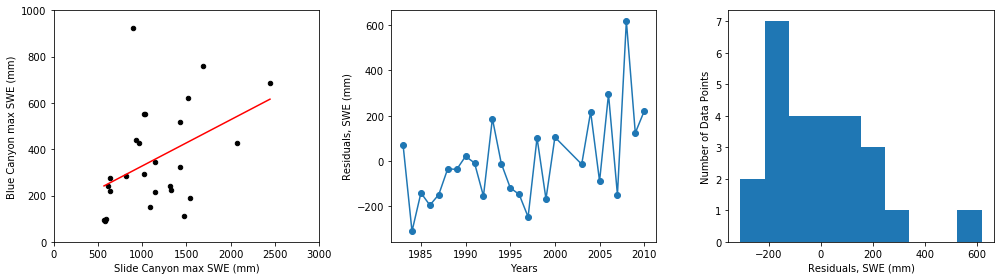

In [10]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(14,4), tight_layout=True)

# Scatterplot
data.plot.scatter(x='SLI_max', y='BLC_max', c='k', ax=ax1);

# Plot the regression line, we only need two points to define a line, use xmin and xmax
ax1.plot([x.min(), x.max()], [B0 + B1*x.min(), B0 + B1*x.max()] , '-r')

ax1.set_xlabel('Slide Canyon max SWE (mm)')
ax1.set_ylabel('Blue Canyon max SWE (mm)');

ax1.set_xlim((0,3000))
ax1.set_ylim((0,1000));

# Plot the residuals
ax2.plot(data.years,residuals,'-o')

ax2.set_xlabel('Years')
ax2.set_ylabel('Residuals, SWE (mm)');

# Plot a histogram of the residuals
ax3.hist(residuals, bins=10)

ax3.set_xlabel('Residuals, SWE (mm)')
ax3.set_ylabel('Number of Data Points');

---

### Linear regression using the scipy library

Now we'll use the `scipy.stats.linregress()` function to do the same thing. Review the documentation or help text for this function before proceeding. 

In [11]:
stats.linregress?

Signature: stats.linregress(x, y=None)
Docstring:
Calculate a linear least-squares regression for two sets of measurements.

Parameters
----------
x, y : array_like
    Two sets of measurements.  Both arrays should have the same length.  If
    only `x` is given (and ``y=None``), then it must be a two-dimensional
    array where one dimension has length 2.  The two sets of measurements
    are then found by splitting the array along the length-2 dimension.  In
    the case where ``y=None`` and `x` is a 2x2 array, ``linregress(x)`` is
    equivalent to ``linregress(x[0], x[1])``.

Returns
-------
slope : float
    Slope of the regression line.
intercept : float
    Intercept of the regression line.
rvalue : float
    Correlation coefficient.
pvalue : float
    Two-sided p-value for a hypothesis test whose null hypothesis is
    that the slope is zero, using Wald Test with t-distribution of
    the test statistic.
stderr : float
    Standard error of the estimated gradient.

See also
---

In [12]:
# use the linear regression function
slope, intercept, rvalue, pvalue, stderr = stats.linregress(data.SLI_max, data.BLC_max)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 127.9143
B1 : 0.1997
R^2 : 0.181
R : 0.425
stderr : 0.087


Do we get the same results as above?

No, our "standard error" is different. Why is that? If you look into the documentation for the lingregress function, you'll see that it calls this output the "standard error of the **gradient**" meaning the standard error of the slope, $B1$.

This is related to the "standard error", $\sigma$ like:

$SE_{B_1} = \displaystyle \frac{\sigma}{SST_x} $ where $SST_x = \displaystyle\sum_{i=1}^{n} (x_i - \bar{x}_i)^2$

Compute the standard error from the standard error of the gradient:

In [13]:
# Compute the SST for x
sst_x = np.sum( (x - np.mean(x))**2 )

# Compute the standard error
sigma = stderr * np.sqrt(sst_x)
print('sigma : {}'.format(np.round(sigma,3)))

sigma : 204.089


This should now match what we solved for manually above.

Finally, plot the result

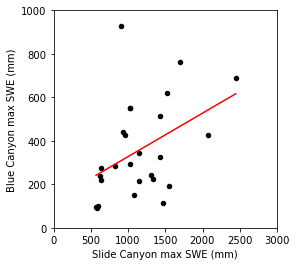

In [14]:
fig, ax = plt.subplots(figsize=(4,4))

# Scatterplot
data.plot.scatter(x='SLI_max', y='BLC_max', c='k', ax=ax);

# Create points for the regression line
x = np.linspace(data.SLI_max.min(), data.SLI_max.max(), data.SLI_max.size) # x coordinates from min and max values of SLI_max
y = slope * x + intercept # y coordinates using the slope and intercept from our linear regression

# Plot the regression line
ax.plot(x, y, '-r')

ax.set_xlabel('Slide Canyon max SWE (mm)')
ax.set_ylabel('Blue Canyon max SWE (mm)');

ax.set_xlim((0,3000))
ax.set_ylim((0,1000));

We've used the slope and intercept from the linear regression, what were the other values the function returned to us?

This function gives us our R value, we can report how well our linear regression fits our data with this or R-squared (you can see in this case linear regression did a poor job)

In [15]:
print('r-value = {}'.format(rvalue))

print('r-squared = {}'.format(rvalue**2))

r-value = 0.4249234045616491
r-squared = 0.18055989974426292


This function also performed a two-sided "Wald Test" (t-distribution) to test if the slope of the linear regression is different from zero (null hypothesis is that the slope is not different from a slope of zero). Be careful using this default statistical test though, is this the test that you really need to use on your data set?

In [16]:
print('p-value = {}'.format(pvalue))

p-value = 0.03047392304371895


And finally it gave us the standard error of the gradient

In [17]:
print('standard error = {}'.format(stderr))

standard error = 0.0868316797949923


**Plot residuals**

We should make a plot of the residuals (actual - predicted values)

In [18]:
residuals = data.BLC_max - y

For a good linear fit, we hope that our residuals are small, don't have any trends or patterns themselves, want them to be normally distributed:

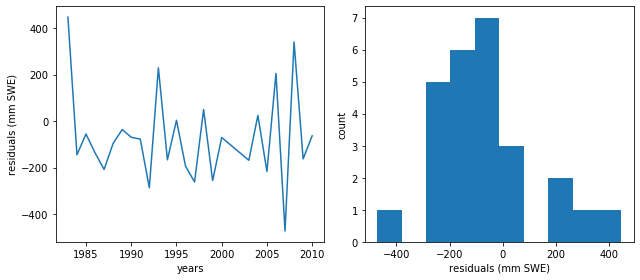

In [19]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4))

ax1.plot(data.years,residuals)
ax1.set_xlabel('years')
ax1.set_ylabel('residuals (mm SWE)')

ax2.hist(residuals)
ax2.set_xlabel('residuals (mm SWE)')
ax2.set_ylabel('count')

f.tight_layout()

That distribution doesn't look quite normal, and there seems to be a negative bias (our predictions are higher then the observations).

There doesn't seem to be a trend in the residuals over time, but they're very noisy.

---

### Making predictions with our linear model

Let's plot what the predictions of Blue Canyon SWE would look like if we were to use this linear model:

In [20]:
# Use our linear model to make predictions:
BLC_pred = slope * data.SLI_max + intercept

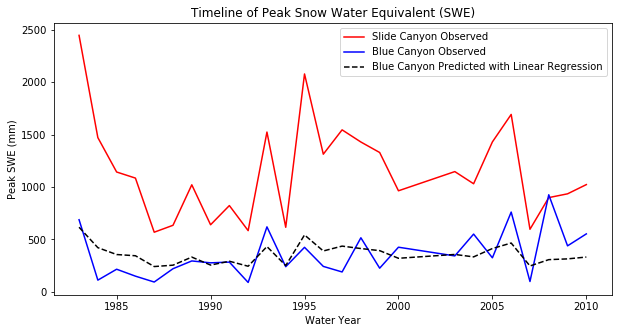

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

data.plot(x='years', y='SLI_max', c='r', ax=ax, label='Slide Canyon Observed')
data.plot(x='years', y='BLC_max', c='b', ax=ax, label='Blue Canyon Observed')

# Plot the predicted SWE at Blue Canyon
ax.plot(data.years, BLC_pred, c='k', linestyle='--', label='Blue Canyon Predicted with Linear Regression')

ax.set_title('Timeline of Peak Snow Water Equivalent (SWE)')
ax.set_xlabel('Water Year')
ax.set_ylabel('Peak SWE (mm)');
plt.legend(loc="best")